# In this notebook the code is developed to solve the VeRoLog solver challenge to optimality. mip is used to create and execute the created MILP. We use the example instance of the VeRoLog challegence since it is rather small. The index of some variables have been moved by 1 since python starts indexing at 0. The formulas in this notebook are written with LaTeX. In mip strict inequalities are not supported

## Imports

In [1]:
import logging
import math as math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import time
import mip as mip

from itertools import product
from sys import stdout as out

In [2]:
logging.basicConfig(filename='VeRoLog MILP', level=logging.INFO,format='%(asctime)s:%(levelname)s:%(message)s')
opt_model = mip.Model(name='VeRoLog',solver_name=mip.CBC)

## Input parameters (the variable used in the formulas are commented next to the variable)

In [3]:
DAYS = 7                                                #T
technicians = [0,1,2,3,4]                                #H
trucks = [i for i in range(3)]                        #K (arbitrarily chosen)
machines = [0,1,2,3]                                         #M
customers = [i for i in range(7)]                    #C

customer_machine_types = [0,2,3,0,1,3,1]           #m_j
machine_size = [2,1,3,2]                                     #s_{m_j}
machine_penalty = [200,200,500,100]                              #pi_j
customer_order_size = [1,1,2,3,1,1,4]              #d_j
start_delivery_window = [0,2,1,4,0,0,2]              #a_j
end_delivery_window =  [6,5,2,6,3,5,4]              #b_j
technician_max_visits = [2,1,5,2,1]                      #r_h
technician_max_distance = [100,100,100,100,50]     #omega_h
technician_skill_set = [[0,1,1,1],[1,1,0,0],[0,0,1,0],[1,1,0,1],[1,1,1,1]]   #g_{h_m}
TRUCK_MAX_DISTANCE = 250                                #delta
TRUCK_CAPACITY = 6                                      #Q
LARGE_NUMBER = 1000                                      #L

TRUCK_DISTANCE_COST = 1                               #beta
TRUCK_DAY_COST = 100                                  #alpha
TRUCK_COST = 100000                                       #gamma
TECHNICIAN_DISTANCE_COST = 1                           #phi
TECHNICIAN_DAY_COST = 100000                              #lambda
TECHNICIAN_COST = 100   

In [4]:
## Alternative to test the consecutive working days constraint
# DAYS = 12                                                #T
# technicians = [0,1]                                #H
# trucks = [i for i in range(3)]                        #K (arbitrarily chosen)
# machines = [0,1,2,3]                                         #M
# customers = [i for i in range(15)]                    #C

# customer_machine_types = [0,2,3,0,1,3,1,3,1,2,0,0,3,2,0]           #m_j
# machine_size = [2,1,3,2]                                     #s_{m_j}
# machine_penalty = [200,200,500,100]                              #pi_j
# customer_order_size = [1,1,2,3,1,1,4,1,1,1,1,1,1,1,1]              #d_j
# start_delivery_window = [0,2,1,4,0,0,2,0,2,1,4,0,0,2,0]              #a_j
# end_delivery_window =  [6,5,2,6,3,5,4,6,5,2,6,3,5,4,5]              #b_j
# technician_max_visits = [2,1]                      #r_h
# technician_max_distance = [100,150]     #omega_h
# technician_skill_set = [[0,1,1,1],[1,1,0,0],[0,0,1,0],[1,1,0,1],[1,1,1,1]]   #g_{h_m}
# TRUCK_MAX_DISTANCE = 250                                #delta
# TRUCK_CAPACITY = 6                                      #Q
# LARGE_NUMBER = 1000                                      #L

# TRUCK_DISTANCE_COST = 1                               #beta
# TRUCK_DAY_COST = 100                                  #alpha
# TRUCK_COST = 100000                                       #gamma
# TECHNICIAN_DISTANCE_COST = 1                           #phi
# TECHNICIAN_DAY_COST = 100000                              #lambda
# TECHNICIAN_COST = 100                                     #mu

### Graph $G=(N,E)$

In [5]:
#nodes: dictionary of x and y coordinates
depot_node = {0:(10,50)}
customer_nodes = {1:(20, 10),2:(50, 5),3:(33, 7),4:(40, 40),5:(70,40),6:(1, 35),7:(1, 35)}   #\mathcal{C}
technician_nodes = {8:(50,5),9:(10,5),10:(25,5),11:(25,60),12:(10,25)}                       #\mathcal{H}
nodes = {**depot_node,**customer_nodes,**technician_nodes}                                   #N
x_nodes = {**depot_node,**customer_nodes}                                                    #N_x
y_nodes = {**customer_nodes,**technician_nodes}                                              #N_y
number_of_nodes = len(nodes)
#edges and cost: every node is connected and the graph is directed
count_0 = 0
count_1 = 0
# we first want the edges that connect the depot to each customer and each customer to each customer, the graph is directed
edges_index = {}                                                                            #E
cost_edges = [[] for i in nodes]
for i in x_nodes:
    count_1 = 0
    for j in x_nodes:
        if i!=j:
            edges_index[(i,j)] = (count_0,count_1)
            cost_edges[i].append(math.ceil(math.sqrt((x_nodes[i][0] - x_nodes[j][0])**2+(x_nodes[i][1]-x_nodes[j][1])**2)))
            count_1 +=1
    count_0 +=1
# # we now want to connect the technician home locations to each node
for tech_node in technician_nodes:
    count_1 = 0
    for cust_node in customer_nodes:
        edges_index[(tech_node,cust_node)] = (count_0,count_1)
        edges_index[(cust_node,tech_node)] = (count_0,count_1+1)
        cost_edges[tech_node].append(math.ceil(math.sqrt((technician_nodes[tech_node][0]-customer_nodes[cust_node][0])**2+(technician_nodes[tech_node][1]-customer_nodes[cust_node][1])**2)))
        cost_edges[tech_node].append(math.ceil(math.sqrt((customer_nodes[cust_node][0]-technician_nodes[tech_node][0])**2+(customer_nodes[cust_node][1]-technician_nodes[tech_node][1])**2)))
        count_1 += 2
    count_0 +=1

In [6]:
# # Alternative to test the consecutive working days constraint
# #nodes: dictionary of x and y coordinates
# depot_node = {0:(10,50)}
# customer_nodes = {1:(20, 10),2:(50, 5),3:(33, 7),4:(40, 40),5:(70,40),6:(1, 35),7:(1, 35),
#                   8:(20, 10),9:(50, 5),10:(33, 7),11:(40, 40),12:(70,40),13:(1, 35),14:(1, 35),15:(50,60)}   #\mathcal{C}
# technician_nodes = {16:(50,5),17:(10,5)}                       #\mathcal{H}
# nodes = {**depot_node,**customer_nodes,**technician_nodes}                                   #N
# x_nodes = {**depot_node,**customer_nodes}                                                    #N_x
# y_nodes = {**customer_nodes,**technician_nodes}                                              #N_y
# number_of_nodes = len(nodes)
# #edges and cost: every node is connected and the graph is directed
# count_0 = 0
# count_1 = 0
# # we first want the edges that connect the depot to each customer and each customer to each customer, the graph is directed
# edges_index = {}                                                                            #E
# cost_edges = [[] for i in nodes]
# for i in x_nodes:
#     count_1 = 0
#     for j in x_nodes:
#         if i!=j:
#             edges_index[(i,j)] = (count_0,count_1)
#             cost_edges[i].append(math.ceil(math.sqrt((x_nodes[i][0] - x_nodes[j][0])**2+(x_nodes[i][1]-x_nodes[j][1])**2)))
#             count_1 +=1
#     count_0 +=1
# # # we now want to connect the technician home locations to each node
# for tech_node in technician_nodes:
#     count_1 = 0
#     for cust_node in customer_nodes:
#         edges_index[(tech_node,cust_node)] = (count_0,count_1)
#         edges_index[(cust_node,tech_node)] = (count_0,count_1+1)
#         cost_edges[tech_node].append(math.ceil(math.sqrt((technician_nodes[tech_node][0]-customer_nodes[cust_node][0])**2+(technician_nodes[tech_node][1]-customer_nodes[cust_node][1])**2)))
#         cost_edges[tech_node].append(math.ceil(math.sqrt((customer_nodes[cust_node][0]-technician_nodes[tech_node][0])**2+(customer_nodes[cust_node][1]-technician_nodes[tech_node][1])**2)))
#         count_1 += 2
#     count_0 +=1

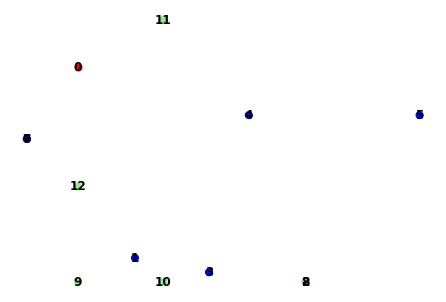

In [7]:
#create and plot the graph with networkx
G_cust = nx.DiGraph()
G_tech = nx.DiGraph()
G_depot = nx.DiGraph()

G_cust.add_nodes_from(customer_nodes)
G_tech.add_nodes_from(technician_nodes)
G_depot.add_nodes_from(depot_node)

pos = {}
for node in G_cust.nodes:
    pos[node] = nodes[node]
for node in G_tech.nodes:
    pos[node] = nodes[node]
for node in G_depot.nodes:
    pos[node] = nodes[node]
    
plt.figure(figsize=[6,4])
nx.draw(G_cust,pos=pos, node_size=50, with_labels=True, font_weight='bold',node_color=["blue" for c in customers])
nx.draw(G_tech,pos=pos, node_size=50, with_labels=True, font_weight='bold',node_color=["lightgreen" for tech in technicians])
nx.draw(G_depot,pos=pos,node_size=50, with_labels=True, font_weight='bold',node_color=['red'])
plt.show()

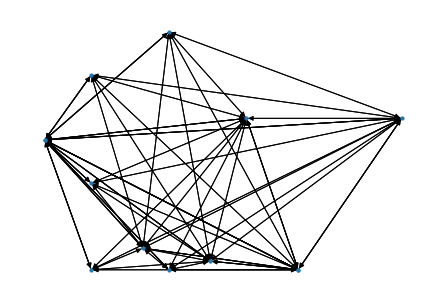

In [8]:
#with edges
G = nx.DiGraph()
for k,v in edges_index.items():
    G.add_edge(*k)
    
plt.figure(figsize=[6,4])
nx.draw(G,pos=pos, node_size=10)
plt.show()

## Data checks

In [9]:
# cost_edges

In [10]:
if not len(technicians) == len(technician_nodes) == len(technician_max_visits) == len(technician_max_distance) == len(technician_skill_set):
    logging.error("ERROR: the technician data is not consistent")

if not len(customer_machine_types) == len(customer_order_size) == len(start_delivery_window) == len(end_delivery_window) ==len(customer_nodes) == len(customers):
    logging.error("ERROR: the customer data is not consistent")

if not len(machines) == len(machine_size) == len(machine_penalty):
    logging.error("ERROR: the machine data is not consistent")

for i in range(len(customer_nodes)):
    if start_delivery_window[i] < 0:
        logging.error("ERROR: the start of delivery window is smaller than 0")
    if start_delivery_window[i] >= end_delivery_window[i]:
        logging.error("ERROR: the start of delivery window is larger or equal than the end")
    if end_delivery_window[i] == DAYS-1:
        end_delivery_window[i] = end_delivery_window[i]-1 #one day is needed to install within horizon so might as well shift it
    if end_delivery_window[i] > DAYS-1:
        logging.error("ERROR: the end of delivery window is outside horizon")

for i in range(len(customer_nodes)):
    if 2*cost_edges[0][i]> TRUCK_MAX_DISTANCE:
        logging.error("ERROR: trucks can't reach customer {0}".format(i))

for i, machine_type in enumerate(customer_machine_types):
    if machine_size[machine_type] * customer_order_size[i] > TRUCK_CAPACITY:
        logging.error("ERROR: customer order is to large for truck capacity")         

tech_dist_check = [0 for i in customers]
for i in customers:
    MachineType = customer_machine_types[i]
    for tech in technicians:
        if technician_skill_set[tech][MachineType] == 1:
            edge_index = edges_index[(tech+len(customers)+1,i+1)]
            if 2*cost_edges[edge_index[0]][edge_index[1]] < technician_max_distance[tech]:
                tech_dist_check[i] = 1
if min(tech_dist_check) == 0:
    logging.error("ERROR: customer location is located too far from technicians")  

## Decision variables

### We have the following decision variables:
### $x_{tkij} \in \{0,1\} \text{: indicates if on day $t$, truck $k$, drives from node $i$ to $j$}$
### $y_{thij} \in \{0,1\} \text{: indicates if on day $t$, technician $h$, drives from node $i$ to $j$}$
### $u_k \in {\rm I\!R} \text{: indicates if truck $k$ is used in the problem}$
### $v_{tk} \in {\rm I\!R} \text{: indicates if on day $t$ truck $k$ is used}$
### $p_h \in {\rm I\!R} \text{: indicates if technician $h$ is used in the problem}$
### $q_{th} \in {\rm I\!R} \text{:  indicates if on day $t$ technician $h$ is used}$
### $z_{tkj} \in {\rm I\!R} \text{: cumulative load on day $t$, in truck $k$, when delivering to $j \in \mathcal{C}$}$
### $w_{th} \in \{0,1\} \text{: indicates if on day $t$ technician $h$ has worked for 5 days in a row}$
### where
### $ u_k \geq 0 \hspace{0.3cm} \forall \hspace{0.1cm} k \in K,                                                 $
### $ v_{tk} \geq 0 \hspace{0.3cm} \forall \hspace{0.1cm} t \in \{1,\ldots,T\}, k \in K,                        $
### $ p_h \geq 0 \hspace{0.3cm} \forall \hspace{0.1cm} h \in H,                                                $
### $ q_{th} \geq 0 \hspace{0.3cm} \forall \hspace{0.1cm} t \in \{1,\ldots,T\}, h \in H, $
### $ z_{tkj} \geq 0 \hspace{0.3cm} \forall \hspace{0.1cm} t \in \{1,\ldots,T\}, k \in K, j \in \mathcal{C} $

In [ ]:
def tech_graph(technician_skill_set):
    """
    Purpose,
        Create a graph that includes the technician node and all the customer location where the technician can install
    Input,
        h, int: technician under consideration
        technician_skill_set, list: the skillset of each technician
        customer_nodes, dict: nodes of customers
    Output,
        G_tech_h, networkx DiGraph for technician h

    """
    for i in customer_nodes:
        if technician_skill_set[h][customer_machine_types[i-1]]:
            print(h,i)
        
    return G_tech_h

In [25]:
if 3 in technician_nodes.keys():
    print('yo')

In [26]:
technician_nodes.keys() - {8}

{9, 10, 11, 12}

In [27]:
len(x_nodes)

8

In [ ]:
#installation can only start one day later than delivery, also no connection between technician homes and depot
# the technicians are disconnected from the customer nodes if their skillset does not allow them to install there
y = [[[]for h in technicians] for t in range(1,DAYS)]
for t in range(DAYS-1):
    for h in technicians:
        for i in customer_nodes:
            y[t][h].append([])
            if technician_skill_set[h][customer_machine_types[i-1]]:
                #if the technician can install on this customer location 
                y[t][h][i-1].append([opt_model.add_var(name="y_{0}_{1}_{2}_{3}".format(t,h,i,j),var_type=mip.BINARY) 
                         for j in y_nodes if i != j and not (j in technician_nodes.keys() - {h+len(x_nodes)})])

#y = [[[[opt_model.add_var(name="y_{0}_{1}_{2}_{3}".format(t,h,i,j),var_type=mip.BINARY) for j in y_nodes if i != j and not (i in technician_nodes or j in technician_nodes)] for i in y_nodes] for h in technicians] for t in range(1,DAYS)]


In [12]:
y = [[[] for h in technicians] for t in range(1,DAYS)]

In [13]:
y[0]

[[], [], [], [], []]

In [81]:
# Binary
#no connection between technician homes
#delivery needs to be fullfilled one day before end of the horizon
x = [[[[opt_model.add_var(name="x_{0}_{1}_{2}_{3}".format(t,k,i,j),var_type=mip.BINARY) for j in x_nodes if j != i] for i in x_nodes] for k in trucks] for t in range(DAYS-1)]

#installation can only start one day later than delivery, also no connection between technician homes and depot
#we take the technician skillset into account as well when connecting technicians to customers
y = [[[[opt_model.add_var(name="y_{0}_{1}_{2}_{3}".format(t,h,i,j),var_type=mip.BINARY) for j in y_nodes if i != j and not (i in technician_nodes and j in technician_nodes)] for i in y_nodes] for h in technicians] for t in range(1,DAYS)]

#technician can only have worked for the past 5 consecutive days on the 7th day in the horizon
if DAYS > 6:
    w = [[opt_model.add_var(name="w_{0}_{1}".format(t,h),var_type=mip.BINARY) for h in technicians] for t in range(6,DAYS)]

# # Continuous
u = [opt_model.add_var(name="u_{0}".format(k),lb=0.0) for k in trucks]

v = [[opt_model.add_var(name="v_{0}_{1}".format(t,k),lb=0.0) for k in trucks] for t in range(DAYS-1)]

p = [opt_model.add_var(name="p_{0}".format(h),lb=0.0) for h in technicians]

q = [[opt_model.add_var(name="q_{0}_{1}".format(t,h),lb=0.0) for h in technicians] for t in range(1,DAYS)]

#delivery needs to be fullfilled one day before end of the horizon
z = [[[opt_model.add_var(name="z_{0}_{1}_{2}".format(t,k,j),lb=0.0) for j in customer_nodes] for k in trucks] for t in range(DAYS-1)]

## Objective function

## $\min \beta \sum\limits_{t=0}^{T-1}\sum\limits_{k \in K}\sum_{(i,j) \in E} x_{tkij}c_{ij} + \gamma \sum\limits_{k \in K} u_k + \alpha \sum\limits_{t=0}^{T-1}\sum\limits_{k \in K}v_{tk} + \phi \sum\limits_{t=1}^{T}\sum\limits_{h \in H}\sum\limits_{(i,j) \in E} y_{thij}c_{ij} + \mu \sum\limits_{h \in H} p_{h} + \lambda \sum\limits_{t=1}^{T}\sum\limits_{h \in H} q_{th} + \sum\limits_{j \in \mathcal{C}} \pi_{m_j} d_j \left(\left(\sum\limits_{t=0}^{T-1}\sum\limits_{i \in N} \left( \sum\limits_{h \in H} (t+1) y_{t+1hij} - \sum\limits_{k \in K} t x_{tkij}\right) \right) - 1\right)$

In [82]:
def calc_edge_cost(var,t,k_h,i,j,edges_index,cost_edges):
    """
    Purpose,
        Calculate the cost to travel an edge given the variable (x or y) and it's index (t,k or h,i,j)
    Input,
        var, mip.Var: the variable we are looking at (x or y)
        t, int: the index of the day
        k_h, int, the index of the truck (k) or the technician (h)
        i, int: the index of the node we are leaving
        j, int: the index of the node we are entering
        edges_index, dict: indicating the index in cost_edges (values) for each edge (keys)
        cost_edges, list: indicating the cost for each edge
    Output,
        edge_cost, cost to travel over this edge
    """
    var_name = var[t][k_h][i][j].name
    var_name_split = var_name.split('_')
    outgoing_node =  int(var_name_split[3])
    incoming_node = int(var_name_split[4])
    edge_index = edges_index[(outgoing_node,incoming_node)]
    edge_cost = cost_edges[edge_index[0]][edge_index[1]]
    
    return edge_cost

In [83]:
c_truck_distance = TRUCK_DISTANCE_COST * (mip.xsum(x[t][k][i][j] * calc_edge_cost(x,t,k,i,j,edges_index,cost_edges) for t in range(DAYS-1) 
                                for k in trucks for i in range(len(x[t][k])) for j in range(len(x[t][k][i]))))
#print(c_truck_distance)

In [84]:
c_truck = TRUCK_COST * mip.xsum(u[k] for k in trucks)
# print(c_truck)

In [85]:
c_truck_day = TRUCK_DAY_COST * mip.xsum(v[t][k] for t in range(DAYS-1) for k in trucks) 
# print(c_truck_day)

In [86]:
c_tech_distance = TECHNICIAN_DISTANCE_COST * mip.xsum(y[t][h][i][j] * calc_edge_cost(y,t,h,i,j,edges_index,cost_edges)
                                                      for t in range(DAYS-1) for h in technicians for i in range(len(y[t][h]))
                                                      for j in range(len(y[t][h][i]))) 
# print(c_tech_distance)

In [87]:
c_tech = TECHNICIAN_COST * mip.xsum(p[h] for h in technicians) 
# print(c_tech)

In [88]:
c_tech_day = TECHNICIAN_DAY_COST * mip.xsum(q[t][h] for t in range(0,DAYS-1) for h in technicians)
# print(c_tech_day)

In [89]:
# # for the penalization we need to find all nodes that go into the customer node
# selected_customer = 5
# for i in x_nodes:
#     if i > selected_customer:
#         print(x[0][0][i][selected_customer].name)
#     elif i < selected_customer:
#         print(x[0][0][i][selected_customer-1].name)

In [90]:
# #delivery day for a customer is t multiplied by x_{t}_{k}_{i}_{selected_customer} for all i that are not the selected_customer
# deliv_days_sel_cust = (mip.xsum(t*x[t][k][i][selected_customer] for t in range(DAYS) for k in trucks for i in x_nodes if i > selected_customer)
#                        + mip.xsum(t*x[t][k][i][selected_customer-1] for t in range(DAYS) for k in trucks for i in x_nodes if i < selected_customer))
# print(deliv_days_sel_cust)

In [91]:
# for j in customer_nodes:
#     print(j)
#     for i in range(len(y[0][0][j-1])+1):
#         if i > j-1:
#             print(y[0][0][i][j-1].name)
#         elif i < j-1:
#             print(y[0][0][i][j-2].name)

In [92]:
# #installation day for a customer is t multiplied by y_{t}_{k}_{i}_{selected_customer} for all i that are not the selected_customer
# install_days_sel_cust = (mip.xsum((t+1)*y[t][h][i][selected_customer-1] for t in range(DAYS-1) for h in technicians for i in range(len(y[0][0][selected_customer-1])+1) if i > selected_customer-1)
#                        + mip.xsum((t+1)*y[t][h][i][selected_customer-2] for t in range(DAYS-1) for h in technicians for i in range(len(y[0][0][selected_customer-1])+1) if i < selected_customer-1))
# print(install_days_sel_cust)

In [93]:
# # the difference between the installation day and delivery day for a customer -1 gives the number of penalized days
# penalized_days_sel_cust = (install_days_sel_cust - deliv_days_sel_cust) - 1
# print(penalized_days_sel_cust)

In [94]:
c_penalty = mip.xsum(machine_penalty[customer_machine_types[j-1]] * customer_order_size[j-1] * 
         ((mip.xsum((t+1)*y[t][h][i][j-1] for t in range(DAYS-1) for h in technicians for i in range(len(y[t][h][j-1])+1) if i > j-1)
         + mip.xsum((t+1)*y[t][h][i][j-2] for t in range(DAYS-1) for h in technicians for i in range(len(y[t][h][j-1])+1) if i < j-1))
         -(mip.xsum(t*x[t][k][i][j] for t in range(DAYS-1) for k in trucks for i in x_nodes if i > j)
         + mip.xsum(t*x[t][k][i][j-1] for t in range(DAYS-1) for k in trucks for i in x_nodes if i < j))
         - 1) for j in customer_nodes)
# print(c_penalty)

In [95]:
objective_func = c_truck_distance + c_truck + c_truck_day + c_tech_distance + c_tech + c_tech_day + c_penalty
opt_model.objective = mip.minimize(objective_func)

## Constraints

### Decision variable used for calculation

### $u_k - x_{tkij} \geq 0 \hspace{0.3cm} \forall \hspace{0.1cm} t \in \{0,\ldots,T-1\}, k \in K, (i,j) \in E$

In [96]:
for t in range(DAYS-1):
    for k in trucks:
        for i in range(len(x[t][k])):
            for j in range(len(x[t][k][i])):
                opt_model += u[k] - x[t][k][i][j] >= 0

### $v_{tk} - x_{tkij} \geq 0 \hspace{0.3cm} \forall \hspace{0.1cm} t \in \{0,\ldots,T-1\}, k \in K, (i,j) \in E$

In [97]:
for t in range(DAYS-1):
    for k in trucks:
        for i in range(len(x[t][k])):
            for j in range(len(x[t][k][i])):
                opt_model += v[t][k] - x[t][k][i][j] >= 0

### $p_h - y_{thij} \geq 0 \hspace{0.3cm} \forall \hspace{0.1cm} t \in \{1,\ldots,T\}, h \in H, (i,j) \in E$

In [98]:
for t in range(DAYS-1):
    for h in technicians:
        for i in range(len(y[t][h])):
            for j in range(len(y[t][h][i])):
                opt_model += p[h] - y[t][h][i][j] >= 0

### $ q_{th} - y_{thij} \geq 0 \hspace{0.3cm} \forall \hspace{0.1cm} t \in \{1,\ldots,T\}, h \in H, (i,j) \in E$

In [99]:
for t in range(DAYS-1):
    for h in technicians:
        for i in range(len(y[t][h])):
            for j in range(len(y[t][h][i])):
                opt_model += q[t][h] - y[t][h][i][j] >= 0

### Truck distance 
### $\sum\limits_{(i,j) \in E_x} x_{tkij} c_{ij} \leq \delta \hspace{0.5cm} \forall \hspace{0.1cm} t \in \{0,\ldots,T-1\}, k \in K$

In [100]:
for t in range(DAYS-1):
    for k in trucks:
         opt_model += (mip.xsum(x[t][k][i][j] * calc_edge_cost(x,t,k,i,j,edges_index,cost_edges) 
                        for i in range(len(x[t][k])) for j in range(len(x[t][k][i])))) <= TRUCK_MAX_DISTANCE, "truck_dist"

### Technician distance
### $\sum\limits_{(i,j) \in E_y} y_{thij} c_{ij} \leq \omega_{h} \hspace{0.5cm} \forall \hspace{0.1cm} t \in \{1,\ldots,T\}, h \in H$

In [101]:
for t in range(DAYS-1):
    for h in technicians:
         opt_model += (mip.xsum(y[t][h][i][j] * calc_edge_cost(y,t,h,i,j,edges_index,cost_edges) 
                        for i in range(len(y[t][h])) for j in range(len(y[t][h][i])))) <= technician_max_distance[h], "tech_dist"

### Technician visits
### $\sum\limits_{i \in N_y}\sum\limits_{j \in \mathcal{C}} y_{thij} \leq r_h \hspace{0.5cm} \forall \hspace{0.1cm} t \in \{1,\ldots,T\}, h \in H, (i \neq j) $

In [102]:
# for i in range(len(y[0][0])):
#     for j in range(len(y[0][0][i])):
#         if int(y[0][0][i][j].name.split("_")[4]) in customer_nodes:
#             print(y[0][0][i][j])

In [103]:
for t in range(DAYS-1):
    for h in technicians:
        opt_model += (mip.xsum(y[t][h][i][j] for i in range(len(y[t][h])) for j in range(len(y[t][h][i]))
                if int(y[t][h][i][j].name.split("_")[4]) in customer_nodes)) <=technician_max_visits[h], "tech_visit"

### Customer delivery (trucks)
### $\sum\limits_{t=0}^{T-1}\sum\limits_{k \in K}\sum\limits_{i \in N_x, i \neq j} x_{tkij} = 1 \hspace{0.5cm} \forall \hspace{0.1cm} j \in \mathcal{C} $

In [104]:
for j in customer_nodes:
    opt_model += (mip.xsum(x[t][k][i][j-1] for t in range(DAYS-1) for k in trucks for i in x_nodes if i<j) + 
    mip.xsum(x[t][k][i][j] for t in range(DAYS-1) for k in trucks for i in x_nodes if i>j)) == 1 , "cust_delivery"

### Customer delivery (technicians)
### $ \sum\limits_{t=1}^{T}\sum\limits_{h \in H}\sum\limits_{i \in N_y, i \neq j} y_{thij} = 1 \hspace{0.5cm} \forall \hspace{0.1cm} j \in \mathcal{C}$

In [105]:
for j in customers:
    opt_model += (mip.xsum(y[t][h][i][j-1] for t in range(DAYS-1) for h in technicians for i in range(len(y[t][h])) if i<j) + 
    mip.xsum(y[t][h][i][j] for t in range(DAYS-1) for h in technicians for i in range(len(y[t][h])) if i>j)) == 1, "tech_delivery"

### Node enter and leave
### $\sum\limits_{i \in N_x, i \neq n} x_{tkin} - \sum\limits_{j \in N_x, j \neq n} x_{tknj} = 0 \hspace{0.5cm} \forall \hspace{0.1cm} t \in \{0,\ldots,T-1\}, k \in K, n \in N_x$

In [106]:
for t in range(DAYS-1):
    for k in trucks:
        for n in x_nodes:
            opt_model += ((mip.xsum(x[t][k][i][n-1] for i in x_nodes if i<n) + mip.xsum(x[t][k][i][n] for i in x_nodes if i>n)) - 
            (mip.xsum(x[t][k][n][j-1]  for j in x_nodes  if n<j) + mip.xsum(x[t][k][n][j]  for j in x_nodes  if n>j))) == 0, 'node_ent_leave_x'

### Customer enter and leave
### $\sum\limits_{i \in N_x, i \neq n} x_{tkin} - \sum\limits_{j \in N_x, j \neq n} x_{tknj} = 0 \hspace{0.5cm} \forall \hspace{0.1cm} t \in \{1,\ldots,T\}, k \in K, n \in \mathcal{C}$

In [107]:
# for n in customer_nodes:
#     print(((mip.xsum(x[0][0][i][n-1] for i in x_nodes if i<n) + mip.xsum(x[0][0][i][n] for i in x_nodes if i>n)) - 
#     (mip.xsum(x[0][0][n][j-1]  for j in x_nodes  if n<j) + mip.xsum(x[0][0][n][j]  for j in x_nodes  if n>j))) == 0)

In [108]:
# for t in range(DAYS):
#     for k in trucks:
#         for n in customer_nodes:
#             opt_model += ((mip.xsum(x[t][k][i][n-1] for i in x_nodes if i<n) + mip.xsum(x[t][k][i][n] for i in x_nodes if i>n)) - 
#             (mip.xsum(x[t][k][n][j-1]  for j in x_nodes  if n<j) + mip.xsum(x[t][k][n][j]  for j in x_nodes  if n>j))) == 0, "cust_ent_leave"

###  $\sum_{i \in N_y,i \neq n} y_{thin} - \sum_{j \in N_y,j \neq n} y_{thnj} = 0 \hspace{0.5cm} \forall \hspace{0.1cm} t \in \{1,\ldots,T\}, h \in H, n \in \mathcal{C}$

In [109]:
for t in range(DAYS-1):
    for h in technicians:
        for n in customers:
            opt_model += ((mip.xsum(y[t][h][i][n-1] for i in range(len(y[t][h])) if i<n) 
                           + mip.xsum(y[t][h][i][n] for i in range(len(y[t][h])) if i>n)) 
                           - mip.xsum(y[t][h][n][j]  for j in range(len(y[t][h][n])))) == 0, "tech_ent_leave"

### Depot/home leave and enter constraint
### $\sum_{j \in N_x} x_{tk0j} - \sum_{j \in N_x} x_{tkj0} = 0\hspace{0.5cm} \forall \hspace{0.1cm} t \in \{1,\ldots,T\}, k \in K$

In [110]:
# #note that for the first sumation the index is shifted since i < j for all j
# for t in range(DAYS):
#     for k in trucks:
#         opt_model += (mip.xsum(x[t][k][0][j-1] for j in x_nodes if j != 0) - 
#         mip.xsum(x[t][k][j][0] for j in x_nodes if j != 0)) == 0, "depot_ent_leave"

### $\sum_{j \in N_y} y_{thi_{h}j} - \sum_{j \in N_y} y_{thji_{h}} = 0 \hspace{0.5cm} \forall \hspace{0.1cm} t \in \{1,\ldots,T\}, h \in H,$

In [111]:
# print(technician_nodes)
# print([h-(len(nodes) - len(technician_nodes)) for h in technician_nodes])
# print(technicians)

In [112]:
# for t in range(DAYS-1):
#     for h in technician_nodes:
#         print(y[t][h-(len(nodes) - len(technician_nodes))][h-1][0].name)

In [113]:
# for h in technician_nodes:
#     print("NEXT")
#     for j in range(len(y[t][h-(len(nodes) - len(technician_nodes))])-len(technician_nodes)):
#         print(h-2)
#         print(y[t][h-(len(nodes) - len(technician_nodes))][j][h-2])

In [114]:
for t in range(DAYS-1):
    for h in technician_nodes:
        opt_model += ((mip.xsum(y[t][h-(len(nodes) - len(technician_nodes))][h-1][j] for j in 
                         range(len(y[t][h-(len(nodes) - len(technician_nodes))][h-1]))))
         + (mip.xsum(y[t][h-(len(nodes) - len(technician_nodes))][j][h-2] for j in 
                        range(len(y[t][h-(len(nodes) - len(technician_nodes))])-len(technician_nodes)))) == 0), "home_ent_leave"

### Delivery window
### $ a_j \sum_{t=0}^{T-1}\sum_{k \in K}\sum_{i \in N_x} x_{tkij} - \sum_{t=0}^{T-1}\sum_{k \in K}\sum_{i \in N_x} t x_{tkij} \leq 0 \hspace{0.5cm} \forall \hspace{0.1cm} j \in \mathcal{C} $

In [115]:
for j in customer_nodes:
    opt_model += start_delivery_window[j-1] * (mip.xsum(x[t][k][i][j-1] for t in range(DAYS-1) for k in trucks for i in x_nodes if i<j) 
      + mip.xsum(x[t][k][i][j] for t in range(DAYS-1) for k in trucks for i in x_nodes if i>j)) - (mip.xsum(t*x[t][k][i][j-1] for t in range(DAYS-1) for k in trucks for i in x_nodes if i<j) 
       + mip.xsum(t*x[t][k][i][j] for t in range(DAYS-1) for k in trucks for i in x_nodes if i>j)) <= 0, "start_delivery_window"

### $ \sum_{t=0}^{T-1}\sum_{k \in K}\sum_{i \in N_x} t x_{tkij} - b_j \leq 0 \hspace{0.5cm} \forall \hspace{0.1cm} j \in \mathcal{C} $

In [116]:
for j in customer_nodes:
    opt_model += (mip.xsum(t*x[t][k][i][j-1] for t in range(DAYS-1) for k in trucks for i in x_nodes if i<j) 
      + mip.xsum(t*x[t][k][i][j] for t in range(DAYS-1) for k in trucks for i in x_nodes if i>j)) - end_delivery_window[j-1] <= 0, "end_delivery_window"

### $    \sum_{t=0}^{T-1}\sum_{k \in K}\sum_{i \in N_x} t x_{tkij} - \sum_{t=1}^{T}\sum_{h \in H}\sum_{i \in N_y} t y_{thij} + 1 \leq 0\hspace{0.5cm} \forall \hspace{0.1cm} j \in \mathcal{C}$

In [117]:
for j in customer_nodes:
    opt_model += ((mip.xsum(t*x[t][k][i][j-1] for t in range(DAYS-1) for k in trucks for i in x_nodes if i<j) 
      + mip.xsum(t*x[t][k][i][j] for t in range(DAYS-1) for k in trucks for i in x_nodes if i>j)) - 
        (mip.xsum((t+1)*y[t][h][i][j-2] for t in range(DAYS-1) for h in technicians for i in range(len(y[t][h][j-1])+1) if i<j-1) 
      + mip.xsum((t+1)*y[t][h][i][j-1] for t in range(DAYS-1) for h in technicians for i in range(len(y[t][h])) if i>j-1)) + 1) <= 0, "start_installation_window"

### $ \sum_{t=1}^{T}\sum_{h \in H}\sum_{i \in N} t y_{thij} - T \leq 0 \hspace{0.5cm} \forall \hspace{0.1cm} j \in \mathcal{C}$

In [118]:
for j in customer_nodes:
    opt_model += (mip.xsum((t+1)*y[t][h][i][j-2] for t in range(DAYS-1) for h in technicians for i in range(len(y[t][h][j-1])+1) if i<j-1) 
      + mip.xsum((t+1)*y[t][h][i][j-1] for t in range(DAYS-1) for h in technicians for i in range(len(y[t][h])) if i>j-1)) - (DAYS-1) <= 0, "end_installation_window" 

### Truck capacity
### $\sum_{i \in N_x, i \neq j}x_{tkij} d_j s_{m_j} - z_{tkj} \leq 0 \hspace{0.5cm} \forall \hspace{0.1cm} t \in \{0,\ldots,T-1\}, k \in K, j \in \mathcal{C}$

In [119]:
def ordersize_tkj(t,k,j,x_nodes,customer_order_size,machine_size,customer_machine_types):
    """
    Purpose: 
        Returns the expression which is used to calculate the ordersize for customer j on day t in truck k,
        based on binary variable x 
    Input:
        t, int: day on which the ordersize is calculated
        k, int: truck for which the ordersize is calculated
        j, int: customer_node for which the ordersize is calculated
        customer_order_size, list: order size of each customer
        machine_size, list: machine size of each machine type
        customer_machine_types, list: type of machine the customer ordered
        x_nodes, dict: with the nodes used to the x variable
    Output:
        ordersize_tkj, mip.entities.LinExpr: linear expression which is used to calculate the ordersize 
    """
    ordersize_j = customer_order_size[j-1] * machine_size[customer_machine_types[j-1]]
    ordersize_tkj = ordersize_j * (mip.xsum(x[t][k][n][j-1] for n in x_nodes if n<j) + mip.xsum(x[t][k][n][j] for n in x_nodes if n>j)) 
    return  ordersize_tkj

In [120]:
for t in range(DAYS-1):
    for k in trucks:
        for j in customer_nodes:
            opt_model += ordersize_tkj(t,k,j,x_nodes,customer_order_size,machine_size
                                       ,customer_machine_types) - z[t][k][j-1] <= 0, "truck_capacity_lower"

### $z_{tkj} \leq Q \hspace{0.5cm} \forall \hspace{0.1cm} t \in \{0,\ldots,T-1\}, k \in K, j \in \mathcal{C}$

In [121]:
for t in range(DAYS-1):
    for k in trucks:
        for j in customer_nodes:
            opt_model += z[t][k][j-1] <= TRUCK_CAPACITY, "truck_capacity_upper"

### Cumulative load calculation
### $z_j - z_i - \sum_{n \in N_x, n \neq j}x_{tknj} d_j s_{m_j} + Q(1-x_{tkij}) \geq 0 \hspace{0.5cm} \forall \hspace{0.1cm} t \in \{0,\ldots,T-1\}, k \in K, i \in \mathcal{C}, j \in \mathcal{C}, i \neq j$

In [122]:
for t in range(DAYS-1):
    for k in trucks:
        for i in range(len(x[t][k])):
            for j in range(len(x[t][k][i])):
                var_name = x[t][k][i][j].name
                var_name_split = var_name.split("_")
                outgoing_node = int(var_name_split[3])
                incoming_node = int(var_name_split[4])
                if (outgoing_node != 0) and (incoming_node != 0) and (outgoing_node != incoming_node):
                    opt_model += z[t][k][incoming_node-1] - z[t][k][outgoing_node-1] - ordersize_tkj(t,k,incoming_node,x_nodes
                                    ,customer_order_size,machine_size,
                                    customer_machine_types) + TRUCK_CAPACITY * (1 - x[t][k][i][j]) >= 0, "cumulative_load"

### Technician skillset
### $g_{hm_{j}} - \sum_{t=1}^{T} \sum_{i \in N_y, i \neq j} y_{thij} \geq 0 \hspace{0.5cm} \forall \hspace{0.1cm} h \in H, j \in \mathcal{C}$

In [123]:
for h in technicians:
    for j in customer_nodes:
        opt_model += technician_skill_set[h][customer_machine_types[j-1]] - (mip.xsum(y[t][h][i][j-2] for t in range(DAYS-1) 
                       for i in range(len(y[t][h][j-1])+1) if i<j-1) + 
              mip.xsum(y[t][h][i][j-1] for t in range(DAYS-1) for i in range(len(y[t][h])) if i>j-1)) >= 0, "tech_skillset" 

### Consecutive work days technicians
### $4 + w_{th} - \sum\limits_{i=t-5}^{t-1} q_{ih} \geq 0  \hspace{0.5cm} \forall \hspace{0.1cm} t \in \{6,\ldots,T\}, h \in H$

In [124]:
for t in range(0,DAYS-6):
    for h in technicians:
        opt_model += 4 + w[t][h] - mip.xsum(q[i][h] for i in range(t,t+5)) >= 0, "set_w_to_1"

### $5w_{th} - \sum\limits_{i=t-5}^{t-1} q_{ih} \leq 0  \hspace{0.5cm} \forall \hspace{0.1cm} t \in \{6,\ldots,T\}, h \in H$

In [125]:
for t in range(0,DAYS-6):
    for h in technicians:
        opt_model += 5*w[t][h] - mip.xsum(q[i][h] for i in range(t,t+5)) <= 0, "set_w_to_0"

### $w_{th} - L(w_{th}-1) - (q_{th}+1) \geq 0  \hspace{0.5cm} \forall \hspace{0.1cm} t \in \{6,\ldots,T\}, h \in H$

In [126]:
L = 1000
for t in range(0,DAYS-6):
    for h in technicians:
        opt_model += w[t][h] - L*(w[t][h]-1) - (q[t+5][h]+1) >= 0, "consecutive_days_t"

### $w_{th} - L(w_{th}-1) - (q_{t+1h}+1) \geq 0 \hspace{0.5cm} \forall \hspace{0.1cm} t \in \{6,\ldots,T-1\}, h \in H$

In [127]:
L = 1000
for t in range(0,DAYS-6-1):
    for h in technicians:
        opt_model += w[t][h] - L*(w[t][h]-1) - (q[t+6][h]+1) >= 0, "consecutive_days_t+1"

## Optimize

In [128]:
opt_model.store_search_progress_log = True
opt_model.search_progress_log.instance = "VeRoLog"
opt_model.search_progress_log.settings = "truck_dist","tech_dist","tech_visit","cust_delivery","tech_delivery","cust_ent_leave","tech_ent_leave","depot_ent_leave","home_ent_leave","start_delivery_window","end_delivery_window","start_installation_window","end_installation_window","truck_capacity","truck_capacity_lower","truck_capacity_upper","cumulative_load","tech_skillset","set_w_to_1","set_w_to_0","consecutive_days_t","consecutive_days_t+1"

In [129]:
opt_model.write("test.lp")

In [130]:
opt_model.optimize(max_seconds=12*60)

<OptimizationStatus.FEASIBLE: 3>

In [131]:
opt_model.search_progress_log.write("TestResults")

## Solution

In [132]:
if opt_model.num_solutions:
    print('route with total cost %g found' % (opt_model.objective_value))

route with total cost 501172 found


### Check if the constraints are satisfied

In [133]:
delivered = []
trucks_used = []
truck_distances = []
truck_delivery_day = {}
for t in range(DAYS-1):
    for k in trucks:
        total_dist = 0
        for i in range(len(x[t][k])):
            for j in range(len(x[t][k][i])):
                if x[t][k][i][j].x >= 0.99:
                    var_name = x[t][k][i][j].name
                    var_name_strip = var_name.split("_")
                    print('On day ',t,' truck ', k,' drives from node ',var_name_strip[3],' to node ',var_name_strip[4])
                    if int(var_name_strip[4]) in customer_nodes.keys():
                        delivered.append(int(var_name_strip[4]))
                        if t < start_delivery_window[int(var_name_strip[4])-1]:
                            print('This order was delivered before the start of the delivery window: ',var_name_strip[4])
                        if t > end_delivery_window[int(var_name_strip[4])-1]:
                            print("This order was delivered too late: ",var_name_strip[4])
                        truck_delivery_day[var_name_strip[4]] = t
                    if k not in trucks_used:
                        trucks_used.append(k)
                    total_dist += calc_edge_cost(x,t,k,i,j,edges_index,cost_edges)
        truck_distances.append(total_dist)
print("The following customers had their machine delivered:",delivered)
print("The following trucks were used:",trucks_used)
print("The trucks drive the following distances: ",truck_distances," the maximum distance is ",TRUCK_MAX_DISTANCE)
installed = []
technicians_used = []
technicians_distances = []
technicians_visits = []
for t in range(DAYS-1):
    for h in technicians:
        total_dist = 0
        total_visits = 0
        for i in range(len(y[t][h])):
            for j in range(len(y[t][h][i])):
                if y[t][h][i][j].x >= 0.99:
                    var_name = y[t][h][i][j].name
                    var_name_strip = var_name.split("_")
                    print('On day ',int(var_name_strip[1]),' technician ', h,' drives from node ',var_name_strip[3],' to node ',var_name_strip[4])
                    if int(var_name_strip[4]) in customer_nodes.keys():
                        installed.append(int(var_name_strip[4]))
                        if int(var_name_strip[1]) <= truck_delivery_day[var_name_strip[4]]:
                            print("This machine was installed too early: ",var_name_strip[4], ", delivery was on day "
                                  ,truck_delivery_day[var_name_strip[4]], "and installation on day ",t)   
                        if technician_skill_set[h][customer_machine_types[int(var_name_strip[4])-1]] == 0:
                            print("The chosen technician does not have the skillset to install this machine")
                    if h not in technicians_used:
                        technicians_used.append(h)     
                    total_dist += calc_edge_cost(y,t,h,i,j,edges_index,cost_edges)
                    if int(var_name_strip[4]) not in technician_nodes.keys():
                        total_visits += 1 

        technicians_distances.append(total_dist)
        technicians_visits.append(total_visits)
print("The following customers had their machine installed:",installed)
print("The following technicians were used:",technicians_used)
print("The technicians drive the following distances: ",technicians_distances," the maximum distance is ",technician_max_distance)
print("The technicians have the following number of visits: ",technicians_visits," the maximum visits is ",technician_max_visits)

On day  2  truck  0  drives from node  0  to node  3
On day  2  truck  0  drives from node  3  to node  5
On day  2  truck  0  drives from node  5  to node  0
On day  3  truck  0  drives from node  0  to node  2
On day  3  truck  0  drives from node  0  to node  6
On day  3  truck  0  drives from node  1  to node  0
On day  3  truck  0  drives from node  2  to node  1
On day  3  truck  0  drives from node  6  to node  0
On day  4  truck  0  drives from node  0  to node  4
On day  4  truck  0  drives from node  0  to node  7
On day  4  truck  0  drives from node  4  to node  0
On day  4  truck  0  drives from node  7  to node  0
The following customers had their machine delivered: [3, 5, 2, 6, 1, 4, 7]
The following trucks were used: [0]
The trucks drive the following distances:  [0, 0, 0, 0, 0, 0, 160, 0, 0, 170, 0, 0, 100, 0, 0, 0, 0, 0]  the maximum distance is  250
On day  3  technician  3  drives from node  3  to node  5
On day  3  technician  3  drives from node  5  to node  3
On 

### check if the decision variables for the number of trucks (days) and technician (days) are correct

In [134]:
for k in trucks:
    print('truck',k,u[k].x)

truck 0 1.0
truck 1 0.0
truck 2 0.0


In [135]:
for k in trucks:
    for t in range(DAYS-1):
        print("Day: ",t,"Truck: ",k,"variable",v[t][k].x)

Day:  0 Truck:  0 variable 0.0
Day:  1 Truck:  0 variable 0.0
Day:  2 Truck:  0 variable 1.0
Day:  3 Truck:  0 variable 1.0
Day:  4 Truck:  0 variable 1.0
Day:  5 Truck:  0 variable 0.0
Day:  0 Truck:  1 variable 0.0
Day:  1 Truck:  1 variable 0.0
Day:  2 Truck:  1 variable 0.0
Day:  3 Truck:  1 variable 0.0
Day:  4 Truck:  1 variable 0.0
Day:  5 Truck:  1 variable 0.0
Day:  0 Truck:  2 variable 0.0
Day:  1 Truck:  2 variable 0.0
Day:  2 Truck:  2 variable 0.0
Day:  3 Truck:  2 variable 0.0
Day:  4 Truck:  2 variable 0.0
Day:  5 Truck:  2 variable 0.0


In [136]:
for h in technicians:
    print('technician',h,p[h].x)

technician 0 0.0
technician 1 0.0
technician 2 1.0
technician 3 1.0
technician 4 0.0


In [137]:
for h in technicians:
    for t in range(DAYS-1):
        print('Day: ',t+1,'Technician: ',h,'variable: ',q[t][h].x)

Day:  1 Technician:  0 variable:  0.0
Day:  2 Technician:  0 variable:  0.0
Day:  3 Technician:  0 variable:  0.0
Day:  4 Technician:  0 variable:  0.0
Day:  5 Technician:  0 variable:  0.0
Day:  6 Technician:  0 variable:  0.0
Day:  1 Technician:  1 variable:  0.0
Day:  2 Technician:  1 variable:  0.0
Day:  3 Technician:  1 variable:  0.0
Day:  4 Technician:  1 variable:  0.0
Day:  5 Technician:  1 variable:  0.0
Day:  6 Technician:  1 variable:  0.0
Day:  1 Technician:  2 variable:  0.0
Day:  2 Technician:  2 variable:  0.0
Day:  3 Technician:  2 variable:  0.0
Day:  4 Technician:  2 variable:  1.0
Day:  5 Technician:  2 variable:  0.0
Day:  6 Technician:  2 variable:  0.0
Day:  1 Technician:  3 variable:  0.0
Day:  2 Technician:  3 variable:  0.0
Day:  3 Technician:  3 variable:  1.0
Day:  4 Technician:  3 variable:  1.0
Day:  5 Technician:  3 variable:  1.0
Day:  6 Technician:  3 variable:  0.0
Day:  1 Technician:  4 variable:  0.0
Day:  2 Technician:  4 variable:  0.0
Day:  3 Tech

In [67]:
for h in technicians:
    for t in range(DAYS-6):
        print('Day: ',t+6,'Technician: ',h,'variable: ',w[t][h].x)

Day:  6 Technician:  0 variable:  0.0
Day:  7 Technician:  0 variable:  0.0
Day:  8 Technician:  0 variable:  0.0
Day:  9 Technician:  0 variable:  0.0
Day:  10 Technician:  0 variable:  0.0
Day:  11 Technician:  0 variable:  0.0
Day:  6 Technician:  1 variable:  0.0
Day:  7 Technician:  1 variable:  0.0
Day:  8 Technician:  1 variable:  0.0
Day:  9 Technician:  1 variable:  0.0
Day:  10 Technician:  1 variable:  0.0
Day:  11 Technician:  1 variable:  0.0


### The variables have the expected values

In [68]:
# f = open("TestResults.plog","r")
# text = f.read()
# text_constraints = text.split(")")[0]
# text_values = text.split(")")[1]
# print(text_constraints.strip("instance: VeRoLogsettings: (").split(","))
